# Bangla Cyberbullying Classification with BiLSTM

This notebook implements a bidirectional LSTM (BiLSTM) model for multi-class classification of Bangla cyberbullying text without data augmentation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize, LabelEncoder
from bnlp import SentencepieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Loading and Exploring Datasets

In [2]:
# 1. Load the dataset
print("Loading dataset...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")

Loading dataset...
Original dataset shape: (41907, 6)


In [3]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [4]:
# Map the labels for the dataset
label_mapping = {"not bully": 0, "troll": 1, "sexual": 2, "religious": 3, "threat": 4}

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].map(label_mapping)

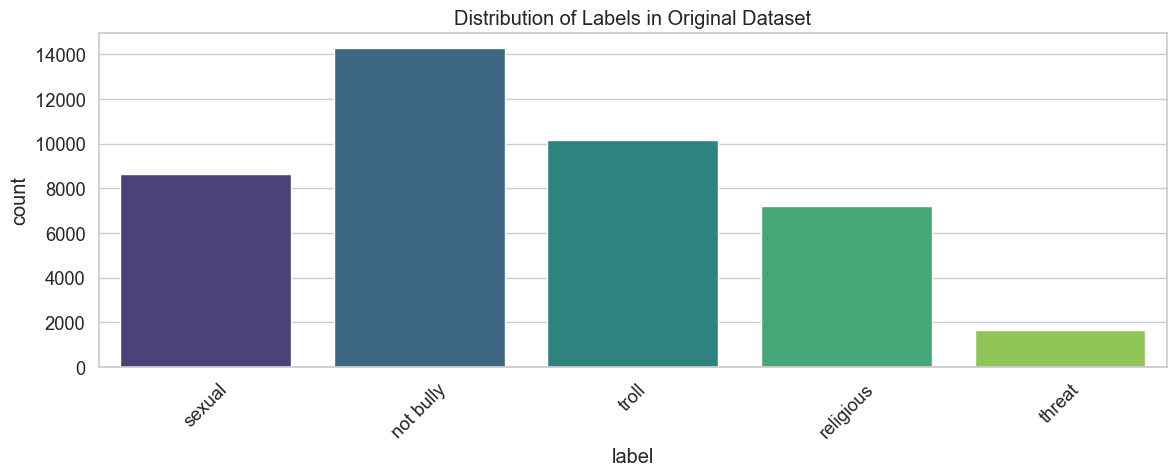

In [5]:
# Check the distribution of labels
plt.figure(figsize=(12, 5))
sns.countplot(x="label", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Labels in Original Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Splitting

In [6]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33525
Test set size: 8382


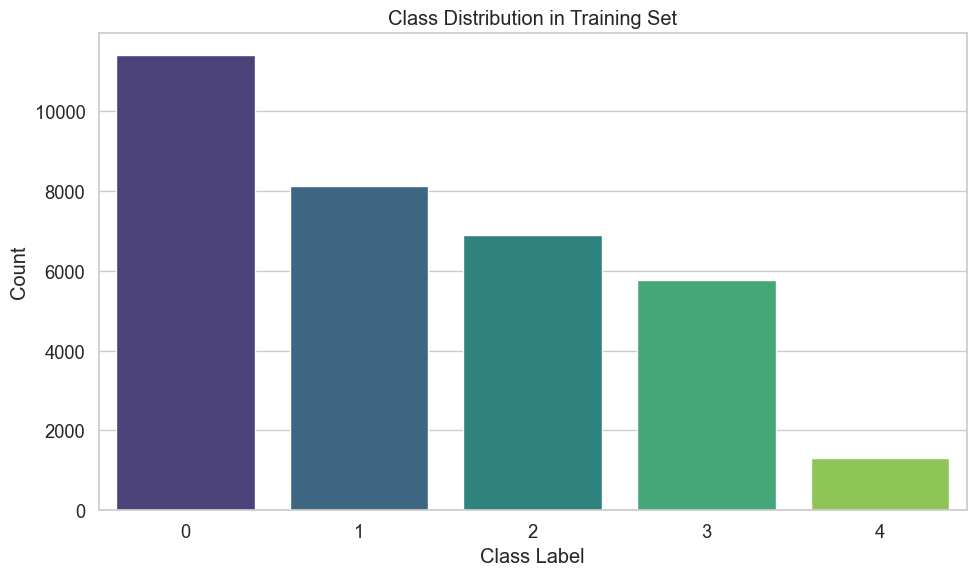

In [7]:
# Visualize the class distribution in the training set
plt.figure(figsize=(10, 6))

sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Sequence Preparation for BiLSTM

In [8]:
# Initialize SentencepieceTokenizer for tokenization
print("Initializing tokenizer...")
sp_tokenizer = SentencepieceTokenizer()

Initializing tokenizer...


In [9]:
def tokenize_text(texts, max_len=100):
    """Tokenize a list of texts and return sequences of token IDs"""
    sequences = []
    for text in texts:
        tokens = sp_tokenizer.tokenize(text)
        # Convert tokens to integers (we'll use index+1 to reserve 0 for padding)
        token_ids = [hash(token) % 20000 + 1 for token in tokens if token.strip()]
        sequences.append(token_ids)

    # Pad sequences to the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    return padded_sequences

In [10]:
# Preprocess the training data
print("Preprocessing training data...")
start_time = time.time()
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences
VOCAB_SIZE = 20000  # Size of vocabulary (number of unique tokens)

# Convert text to sequences of token IDs
X_train_sequences = tokenize_text(X_train, MAX_SEQUENCE_LENGTH)
print(f"Training data preprocessing completed in {time.time() - start_time:.2f} seconds")
print(f"Training sequence shape: {X_train_sequences.shape}")

Preprocessing training data...
Training data preprocessing completed in 5.25 seconds
Training sequence shape: (33525, 100)


In [11]:
# Preprocess test data
print("Preprocessing testing data...")
start_time = time.time()
X_test_sequences = tokenize_text(X_test, MAX_SEQUENCE_LENGTH)
print(f"Testing data preprocessing completed in {time.time() - start_time:.2f} seconds")
print(f"Testing sequence shape: {X_test_sequences.shape}")

# Convert labels to categorical format for neural network
num_classes = 5  # Based on the label mapping
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Preprocessing testing data...
Testing data preprocessing completed in 1.22 seconds
Testing sequence shape: (8382, 100)


## 5. Building and Training BiLSTM Model

In [12]:
# Configure and build BiLSTM model
print("Building BiLSTM model...")

# Define model parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.3

# Build the model
model = Sequential([
    # Embedding layer - maps token IDs to dense vectors
    Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH, mask_zero=True),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(DROPOUT_RATE),
    
    # Second LSTM layer
    Bidirectional(LSTM(LSTM_UNITS)),
    Dropout(DROPOUT_RATE),
    
    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Building BiLSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Set up callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='../../models/lstm/best_model_no_augment.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
print("Training BiLSTM model...")
start_time = time.time()

history = model.fit(
    X_train_sequences,
    y_train_cat,
    validation_split=0.1,  # 10% of training data for validation
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training BiLSTM model...
Epoch 1/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6414 - loss: 0.9467

943/943 ━━━━━━━━━━━━━━━━━━━━ 412s 267ms/step - accuracy: 0.6415 - loss: 0.9465 - val_accuracy: 0.8044 - val_loss: 0.5632
Epoch 2/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 203s 215ms/step - accuracy: 0.8371 - loss: 0.4901 - val_accuracy: 0.8008 - val_loss: 0.6100
Epoch 3/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 202s 213ms/step - accuracy: 0.8766 - loss: 0.3877 - val_accuracy: 0.7808 - val_loss: 0.6753
Epoch 4/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 202s 215ms/step - accuracy: 0.8899 - loss: 0.3350 - val_accuracy: 0.7871 - val_loss: 0.6930
Model trained in 1019.31 seconds


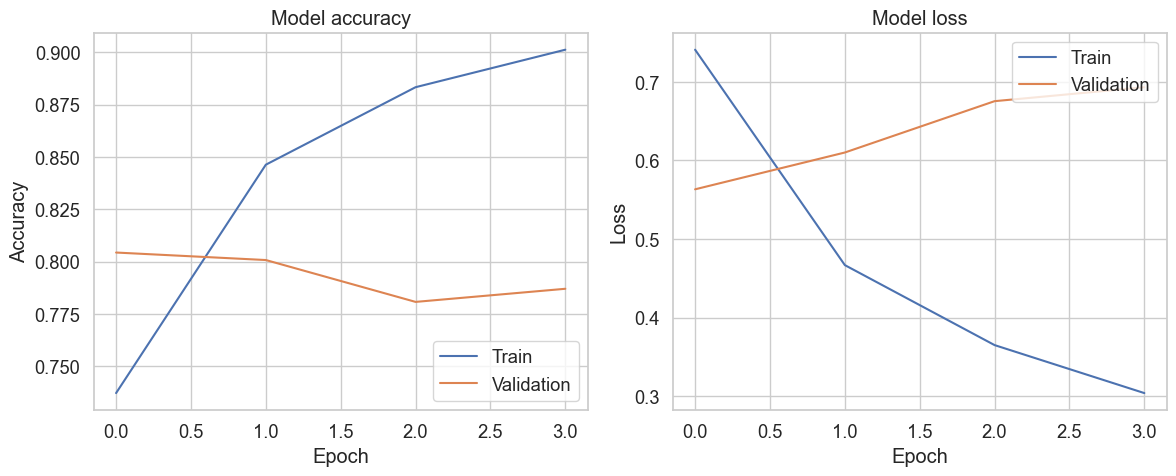

In [14]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics

In [15]:
# Evaluate the model on test data
print("Evaluating model...")
test_loss, test_acc = model.evaluate(X_test_sequences, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate basic metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1 = f1_score(y_test_classes, y_pred_classes, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Test accuracy: 0.7987
Test loss: 0.5943
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step
Accuracy: 0.7987
Precision: 0.8000
Recall: 0.7987
F1 Score: 0.7985


In [16]:
# Display classification report
print("Classification Report:")
print(
    classification_report(
        y_test_classes,
        y_pred_classes,
        target_names=list(label_mapping.keys()),
        digits=5,
    )
)

Classification Report:
              precision    recall  f1-score   support

   not bully    0.80679   0.84187   0.82395      2852
       troll    0.72260   0.72723   0.72491      2031
      sexual    0.78330   0.79374   0.78849      1726
   religious    0.91009   0.86279   0.88581      1443
      threat    0.82449   0.61212   0.70261       330

    accuracy                        0.79874      8382
   macro avg    0.80945   0.76755   0.78515      8382
weighted avg    0.80003   0.79874   0.79852      8382



## 7. Confusion Matrix Visualization

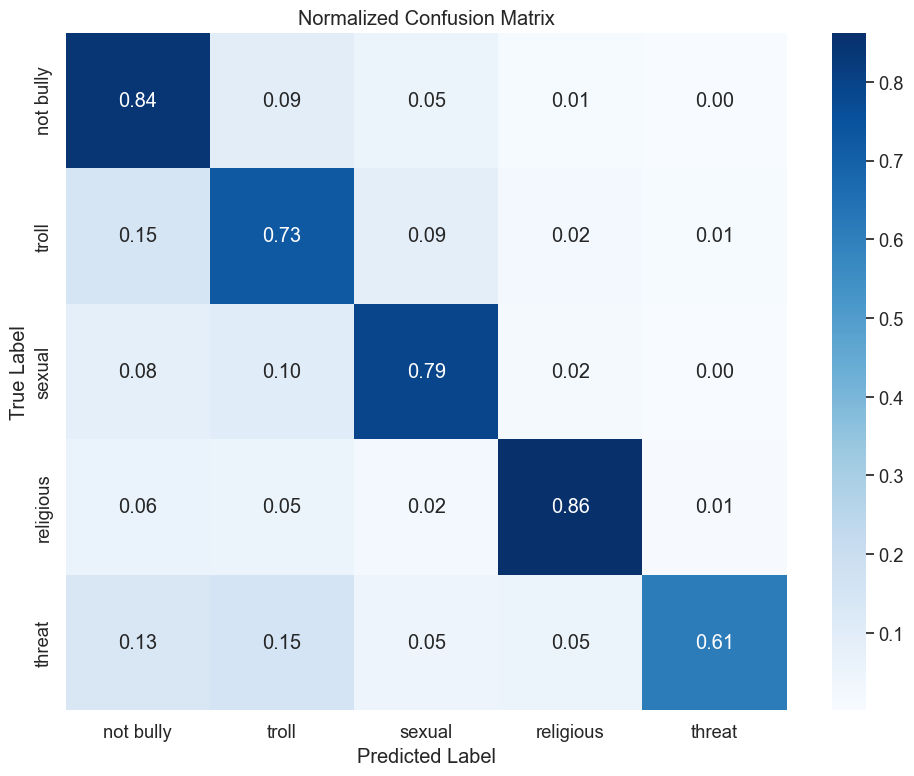

In [17]:
# Create and display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Attention Visualization for BiLSTM

In [18]:
# Since we don't have an attention layer in our current model,
# we can instead analyze the class activation by looking at some examples
def predict_and_explain(text, actual_label=None):
    # Tokenize and convert to sequence
    sequence = tokenize_text([text], MAX_SEQUENCE_LENGTH)
    # Get prediction
    prediction = model.predict(sequence)[0]
    predicted_class = np.argmax(prediction)
    
    # Print results
    print(f"Text: {text}")
    if actual_label is not None:
        print(f"Actual class: {list(label_mapping.keys())[actual_label]}")
    print(f"Predicted class: {list(label_mapping.keys())[predicted_class]}")
    print("Class probabilities:")
    for i, class_name in enumerate(label_mapping.keys()):
        print(f"  {class_name}: {prediction[i]:.4f}")
    print("\n")
    
    return predicted_class, prediction

# Let's examine some examples from the test set
sample_indices = np.random.choice(range(len(X_test)), 5, replace=False)
for idx in sample_indices:
    text = X_test.iloc[idx]
    label = y_test.iloc[idx]
    predict_and_explain(text, label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: তোই ছিলে হ্যাঁ দেখি তোই একটা মুখোসদাড়ি নাস্তিক তোরে বাঁশ ইচ্ছা করতাছে
Actual class: religious
Predicted class: religious
Class probabilities:
  not bully: 0.0032
  troll: 0.0115
  sexual: 0.0038
  religious: 0.9726
  threat: 0.0089


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Text: অবশেষে নারী বাদি মাগুদের কাতারে নাম লিখালে পাবলিক পিগারে আগুন ধরাইচত রে দেখ পাপলিক কিভাবে বাশ দেয়
Actual class: not bully
Predicted class: troll
Class probabilities:
  not bully: 0.1118
  troll: 0.4971
  sexual: 0.3422
  religious: 0.0245
  threat: 0.0244


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Text: চুদিয়া দিমু
Actual class: sexual
Predicted class: sexual
Class probabilities:
  not bully: 0.0170
  troll: 0.0874
  sexual: 0.8495
  religious: 0.0252
  threat: 0.0209


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: অরেহ বাটপার
Actual class: troll
Predicted class: troll
Class probabilities:
  not bully: 0.1935
  troll: 0.7265
  sexual: 0.0661
  religious: 0.0081
  threat: 0.0

## 9. ROC Curve Analysis

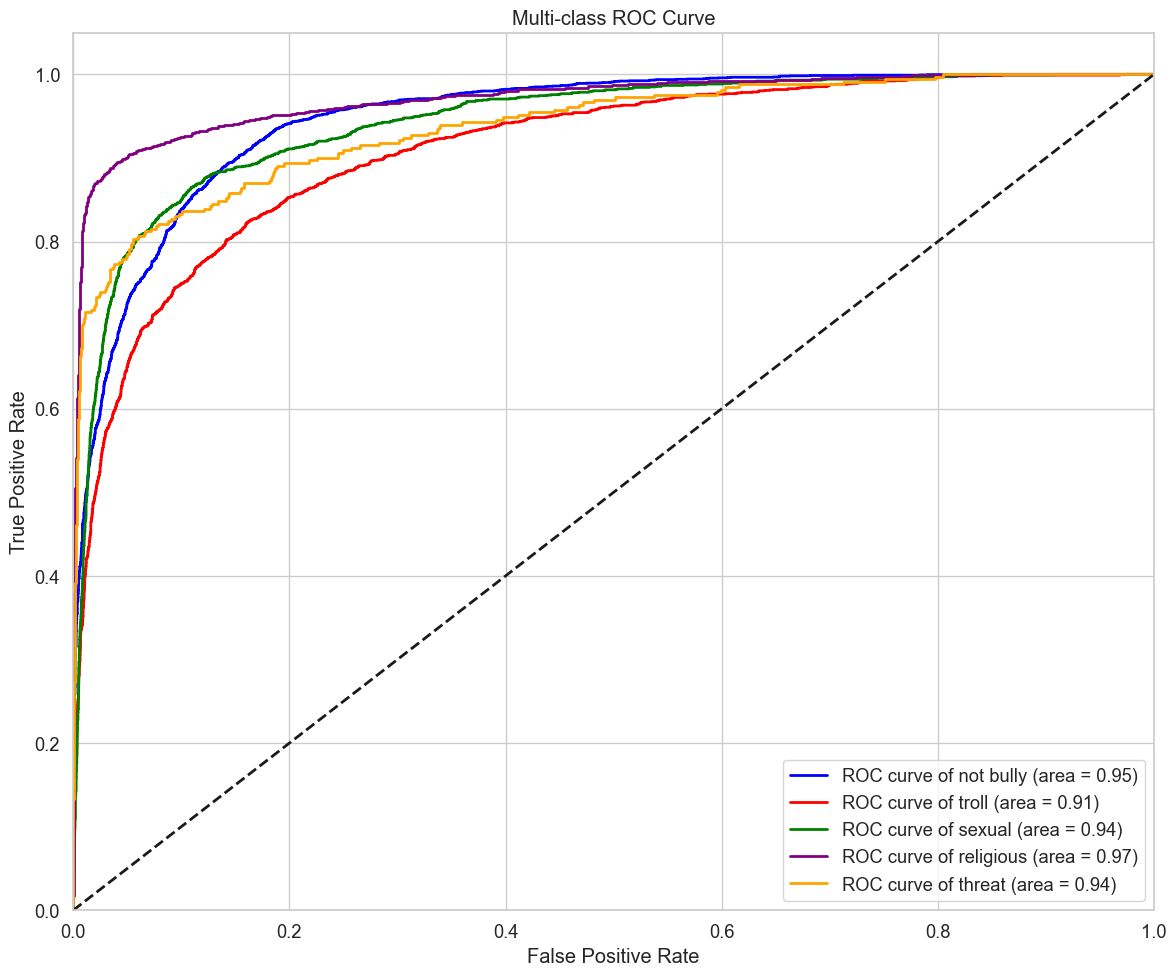

In [19]:
# ROC Curve and AUC for each class
# Calculate ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = cycle(["blue", "red", "green", "purple", "orange"])
class_names = list(label_mapping.keys())

for i, color, class_name in zip(range(5), colors, class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of {class_name} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

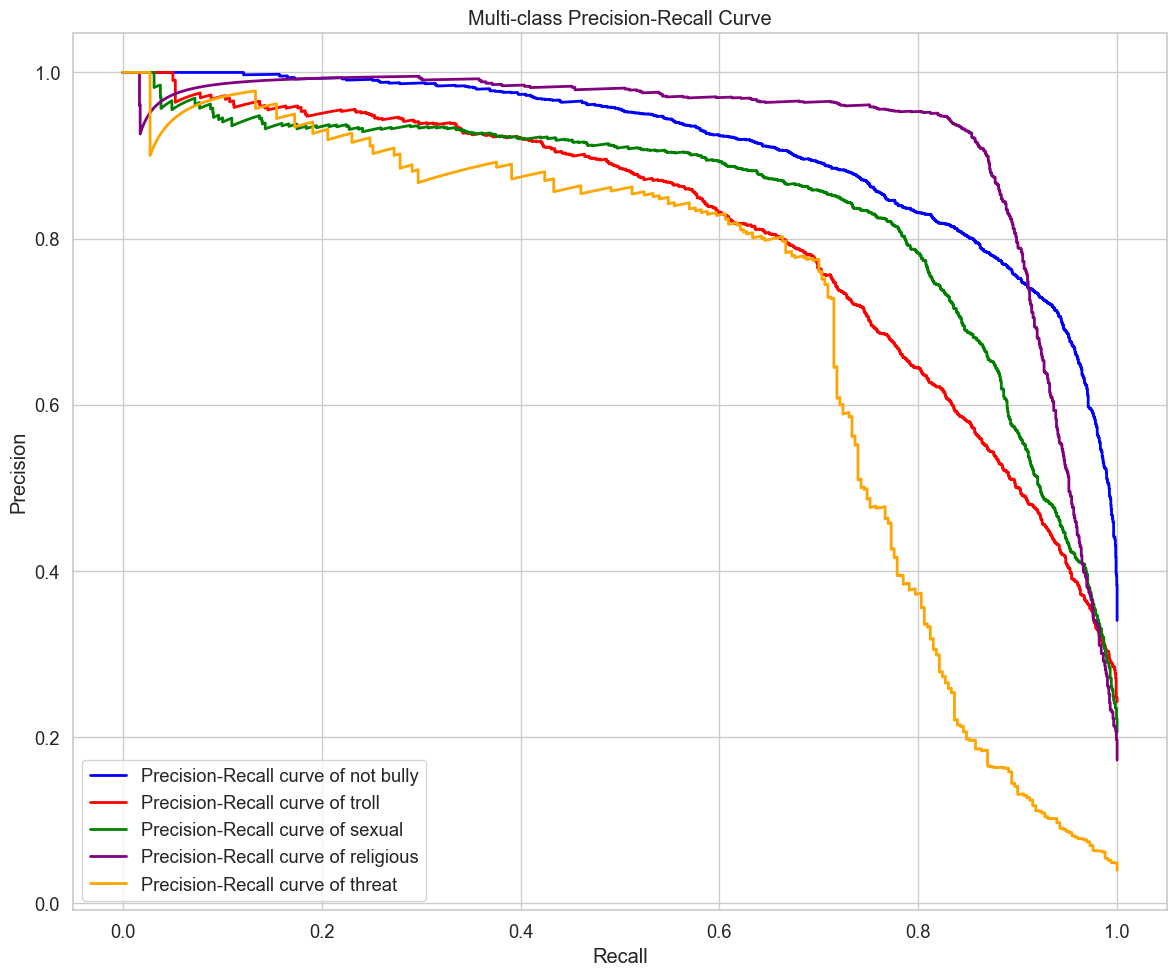

In [20]:
# Calculate Precision-Recall curve for each class
precision = {}
recall = {}
plt.figure(figsize=(12, 10))

for i, color, class_name in zip(range(5), colors, class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_test_cat[:, i], y_pred_proba[:, i])
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Precision-Recall curve of {class_name}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 11. Model Summary and Saving

In [21]:
# Summary of the model
print("Model Summary:")
print(f"Total samples in training set: {len(X_train)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Model Summary:
Total samples in training set: 33525
Total samples in test set: 8382
Sequence length: 100
Vocabulary size: 20000
Final model accuracy on test set: 0.7987
Training time: 1019.31 seconds


In [22]:
# Save the model
model.save("../../models/lstm/no_augment_multiclass_lstm_model.h5")
print("Model saved successfully!")

Model saved successfully!
